<a href="https://colab.research.google.com/github/N4tth/taller2-RN/blob/main/vanillaRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import itertools
import pandas as pd
import kagglehub
import requests

c:\Users\Laura\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Character-level language modeling

In [3]:
#load dataset
dataset_path = kagglehub.dataset_download("new-york-city/nyc-dog-names")
print("Ruta del dataset descargado:", dataset_path)

for f in os.listdir(dataset_path):
    if f.endswith(".csv"):
        csv_path = os.path.join(dataset_path, f)
        break


df = pd.read_csv(csv_path)
print("Dataset cargado correctamente")

print("Shape:", df.shape)
print("Columnas:", df.columns.tolist())
print(df.head())

Ruta del dataset descargado: C:\Users\Laura\.cache\kagglehub\datasets\new-york-city\nyc-dog-names\versions\1
Dataset cargado correctamente
Shape: (16220, 2)
Columnas: ['Row_Labels', 'Count_AnimalName']
  Row_Labels  Count_AnimalName
0          1                 1
1          2                 2
2      40804                 1
3      90201                 1
4      90203                 1


In [4]:
#Preprocessing
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_#]+', '', regex=True)
print("Columnas limpias: ", df.columns.tolist())

col_name = None
col_count = None

for c in df.columns:
  if "row" in c.lower():
      col_name = c
  if "count" in c.lower():
    col_count = c
if not col_name or not col_count:
  raise ValueError("No se encontraron columnas de nombres o conteo")
print(f"Usando columnas → Nombres: {col_name}, Conteos: {col_count}")

names = df[col_name].dropna().astype(str).tolist()
counts = df[col_count].fillna(1).astype(int).tolist()

clean_names = []
for name, count in zip(names, counts):
  name = name.lower().strip()
  name = re.sub(r'[^a-zñáéíóú ]', '', name)
  if 2 <= len(name) <=12:
    repetitions = min(count, 10)
    clean_names.extend([name] * repetitions)
print(f"total nombres limpios: {len(clean_names)}")
print("Ejemplos: ", clean_names[:10])
#Corpus
text = "\n".join(clean_names)
print(f"Longitud total del texto: {len(text)} carácteres")

#Tokenization
chars = sorted(list(set(text)))
char_to_int = {ch:i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)

print(f"Num caracteres únicos: {vocab_size}")
print("Ejemplos vocabulario:", chars[:20])

def get_subset_text(text, size):
  if len(text) < size:
    size = len(text)
  return text[:size]


Columnas limpias:  ['Row_Labels', 'Count_AnimalName']
Usando columnas → Nombres: Row_Labels, Conteos: Count_AnimalName
total nombres limpios: 43391
Ejemplos:  ['march', 'march', 'april', 'april', 'april', 'april', 'april', 'april', 'april', 'april']
Longitud total del texto: 290009 carácteres
Num caracteres únicos: 33
Ejemplos vocabulario: ['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's']


seq_length. Que es el número de neuronas recurrentes. 64, 128, 256
words. Tamaño del conjunto de datos. 5000, 20000, 50000
max_iter. Número de iteraciones/época. 30, 50, 80


In [5]:
#experiment configurations
seq_lengths = [64, 128, 256]
dataset_sizes = [5000, 20000, 50000]
max_iters = [30, 50, 80]
clip_options = [True, False]

experiments = list(itertools.product(seq_lengths, dataset_sizes, max_iters, clip_options))
results = []

# Word-level language modeling

In [6]:
#load dataset
URL = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
text_shakespeare = requests.get(URL).text
print(text_shakespeare[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [7]:
#preprocessing
text_shakespeare = text_shakespeare.lower().replace('\r', ' ').replace('\n', ' ')
tokens_shakespeare = re.findall(r"[a-z]+'?[a-z]+|[a-z]+", text_shakespeare)
vocab = sorted(set(tokens_shakespeare))
word_to_int = {w: i for i, w in enumerate(vocab)}
int_to_word = {i: w for w, i in word_to_int.items()}
vocab_size = len(vocab)

print(f"Palabras totales: {len(tokens_shakespeare)}")
print(f"Palabras únicas (vocab_size): {vocab_size}")
print("Ejemplos de tokens:", tokens_shakespeare[:20])

encoded = [word_to_int[w] for w in tokens_shakespeare]
print("Ejemplos de secuencia codificada:", encoded[:20])

Palabras totales: 203839
Palabras únicas (vocab_size): 12373
Ejemplos de tokens: ['first', 'citizen', 'before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak', 'all', 'speak', 'speak', 'first', 'citizen', 'you', 'are', 'all', 'resolved', 'rather']
Ejemplos de secuencia codificada: [4080, 1879, 894, 11907, 8203, 431, 4464, 5043, 6603, 9946, 295, 9946, 9946, 4080, 1879, 12348, 509, 295, 8825, 8541]


In [8]:
#experiment configurations
seq_lengths_shakespeare = [64, 128, 256]
dataset_sizes_shakespeare = [5000, 20000, 50000]
max_iters_shakespeare = [30, 50, 80]
clip_options_shakespeare = [True, False]

experiments_shakespeare = list(itertools.product(seq_lengths_shakespeare, dataset_sizes_shakespeare, max_iters_shakespeare, clip_options_shakespeare))
results_shakespeare = []

# Vanilla Neural Network

In [23]:
#Vanilla neural network from https://lucyliu-ucsb.github.io/posts/Backpropagation-of-a-vanilla-RNN with modifications
class VanillaRNN:
    def __init__(self, n_x, n_h, seq_length, learning_rate):
        self.n_x = n_x
        self.n_h = n_h
        self.seq_length = seq_length
        self.learning_rate = learning_rate

        self.Wxh = np.random.randn(n_h, n_x) * 0.01
        self.Whh = np.random.randn(n_h, n_h) * 0.01
        self.Why = np.random.randn(n_x, n_h) * 0.01
        self.bh = np.zeros((n_h, 1))
        self.by = np.zeros((n_x, 1))


        self.mWxh = np.zeros_like(self.Wxh)
        self.mWhh = np.zeros_like(self.Whh)
        self.mWhy = np.zeros_like(self.Why)
        self.mbh = np.zeros_like(self.bh)
        self.mby = np.zeros_like(self.by)

    def forward_pass(self, inputs, targets, hprev):
        x, h, y, p = {}, {}, {}, {}
        h[-1] = np.copy(hprev)
        loss = 0

        for t in range(len(inputs)):
            x[t] = np.zeros((self.n_x, 1))
            x[t][inputs[t]] = 1
            h[t] = np.tanh(self.Wxh @ x[t] + self.Whh @ h[t-1] + self.bh)
            y[t] = self.Why @ h[t] + self.by
            p[t] = np.exp(y[t]) / np.sum(np.exp(y[t]))
            loss -= np.log(p[t][targets[t], 0])

        return loss, x, h, p

    def backpropagation(self, x, h, p, targets, clip=True):
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dhnext = np.zeros_like(h[0])

        for t in reversed(range(self.seq_length)):
            dy = np.copy(p[t])
            dy[targets[t]] -= 1
            dWhy += dy @ h[t].T
            dby += dy
            dh = self.Why.T @ dy + dhnext
            dhraw = (1 - h[t] * h[t]) * dh
            dbh += dhraw
            dWxh += dhraw @ x[t].T
            dWhh += dhraw @ h[t-1].T
            dhnext = self.Whh.T @ dhraw

        # Clipping enabling. Since there's no interface, the parameter "clip" functions as a switch
        if clip:
            for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
                np.clip(dparam, -5, 5, out=dparam)

        return dWxh, dWhh, dWhy, dbh, dby

    def update_para(self, dWxh, dWhh, dWhy, dbh, dby):
        for param, dparam, mem in zip(
            ['Wxh', 'Whh', 'Why', 'bh', 'by'],
            [dWxh, dWhh, dWhy, dbh, dby],
            ['mWxh', 'mWhh', 'mWhy', 'mbh', 'mby']
        ):
            setattr(self, mem, getattr(self, mem) + dparam * dparam)
            setattr(self, param, getattr(self, param) -
                    self.learning_rate * dparam / np.sqrt(getattr(self, mem) + 1e-8))

    def train(self, text, char_to_int, int_to_char, max_iter=10000, clip=True):
        iter_num, pos = 0, 0
        loss_list, perplexity_list = [], []
        hprev = np.zeros((self.n_h, 1))
        loss = -np.log(1.0 / self.n_x) * self.seq_length

        while iter_num < max_iter:
            if pos + self.seq_length + 1 >= len(text) or iter_num == 0:
                hprev = np.zeros((self.n_h, 1))
                pos = 0

            inputs = [char_to_int[ch] for ch in text[pos:pos+self.seq_length]]
            targets = [char_to_int[ch] for ch in text[pos+1:pos+self.seq_length+1]]
            pos += self.seq_length

            # Forward pass
            loss, x, h, p = self.forward_pass(inputs, targets, hprev)
            loss_list.append(loss)
            #Perplexity
            perplexity_list.append(np.exp(loss / self.seq_length))

            # Backprop
            dWxh, dWhh, dWhy, dbh, dby = self.backpropagation(x, h, p, targets, clip=clip)
            self.update_para(dWxh, dWhh, dWhy, dbh, dby)
            hprev = h[self.seq_length - 1]

            if iter_num % 1000 == 0:
                print(f"Iteración {iter_num} - Loss: {loss:.3f} - Perplejidad: {np.exp(loss/self.seq_length):.3f}")
            iter_num += 1

        return loss_list, perplexity_list
    def make_sample(self, hprev, seed_ix, n):
        """
        sample a length n sequence from the model
        """
        x = np.zeros((self.n_x, 1))
        x[seed_ix] = 1
        ixes = []
        h = np.copy(hprev)

        for t in range(n):
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            y = self.Why @ h + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            ix = np.random.choice(range(self.n_x), p = p.ravel())
            x = np.zeros((self.n_x, 1))
            x[ix] = 1
            ixes.append(ix)
        return ixes

    #Graphs
    def plot_loss(self, loss_list):
        plt.figure(figsize=(8, 5))
        plt.plot(loss_list, label="Loss", color='blue')
        plt.title("Curva de pérdida vs iteraciones")
        plt.xlabel("Iteraciones")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_perplexity(self, perplexity_list):
        plt.figure(figsize=(8, 5))
        plt.plot(perplexity_list, label="Perplejidad", color='orange')
        plt.title("Curva de perplejidad vs iteraciones")
        plt.xlabel("Iteraciones")
        plt.ylabel("Perplejidad")
        plt.legend()
        plt.grid(True)
        plt.show()



# Character-level language modeling experiments

Total de experimentos Character-level: 5

=== CHARACTER-LEVEL - EXPERIMENTO 1/5 ===
Neuronas recurrentes: 64
Tamaño del dataset: 5000
Iteraciones/Épocas: 50
Clipping de gradientes: True
Iniciando entrenamiento...
Iteración 0 - Loss: 223.816 - Perplejidad: 33.021

--- Generando gráficas para Experimento 1 ---


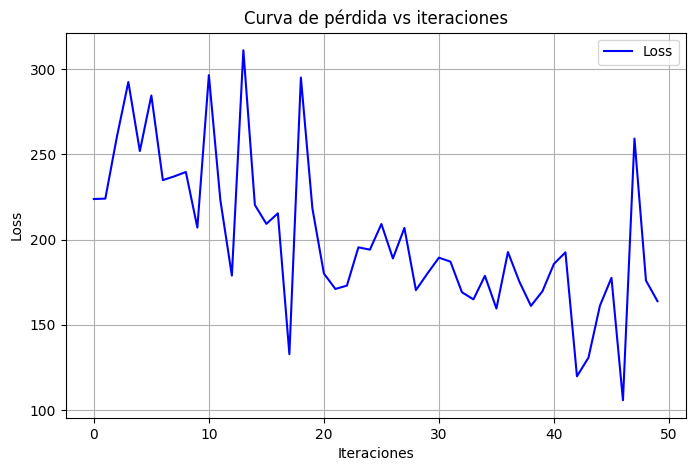

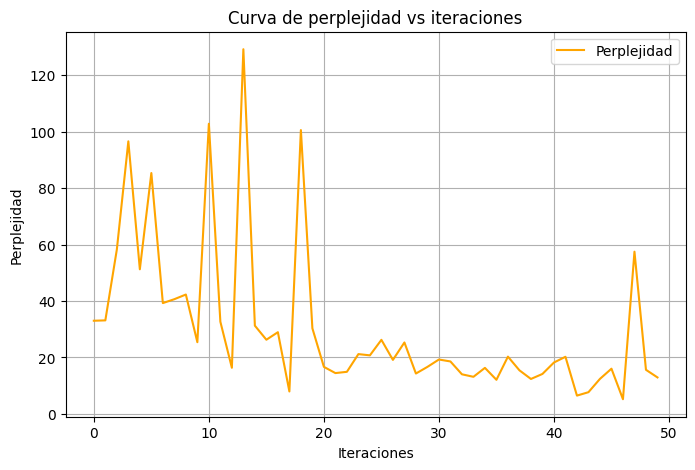

→ Nombre generado de ejemplo: adeaaiestc
✓ Experimento 1 completado - Loss final: 163.8786, Perplexity final: 12.9436

=== CHARACTER-LEVEL - EXPERIMENTO 2/5 ===
Neuronas recurrentes: 128
Tamaño del dataset: 20000
Iteraciones/Épocas: 50
Clipping de gradientes: True
Iniciando entrenamiento...
Iteración 0 - Loss: 447.493 - Perplejidad: 32.985

--- Generando gráficas para Experimento 2 ---


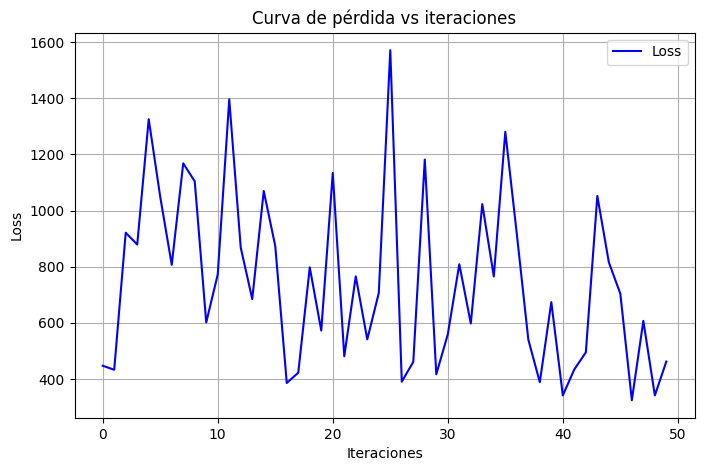

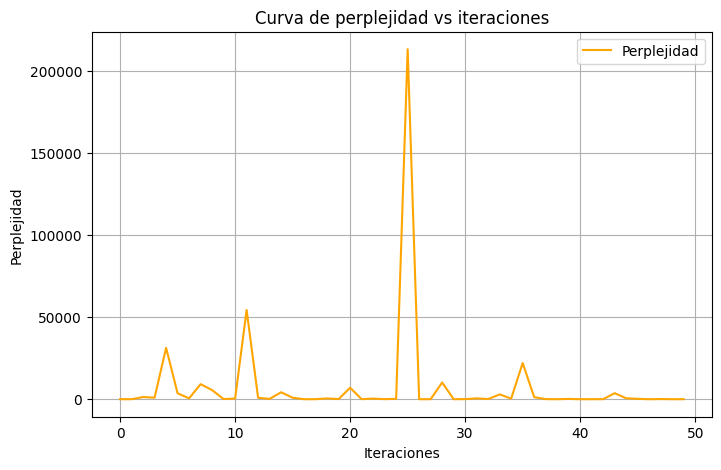

→ Nombre generado de ejemplo: icrlig
sib
✓ Experimento 2 completado - Loss final: 462.5651, Perplexity final: 37.1064

=== CHARACTER-LEVEL - EXPERIMENTO 3/5 ===
Neuronas recurrentes: 256
Tamaño del dataset: 50000
Iteraciones/Épocas: 50
Clipping de gradientes: True
Iniciando entrenamiento...
Iteración 0 - Loss: 895.030 - Perplejidad: 32.990

--- Generando gráficas para Experimento 3 ---


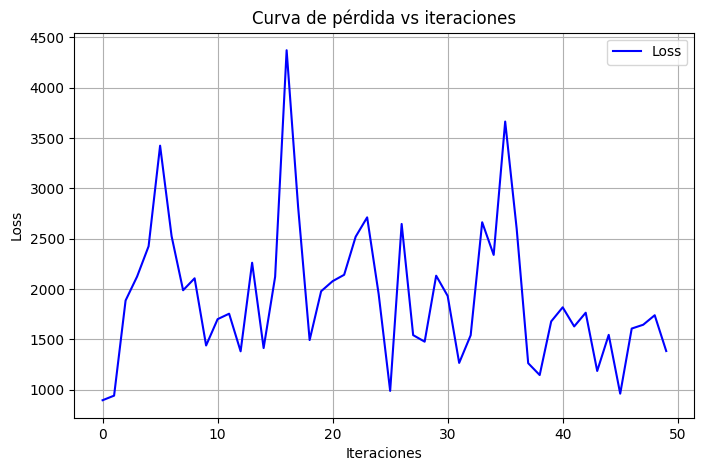

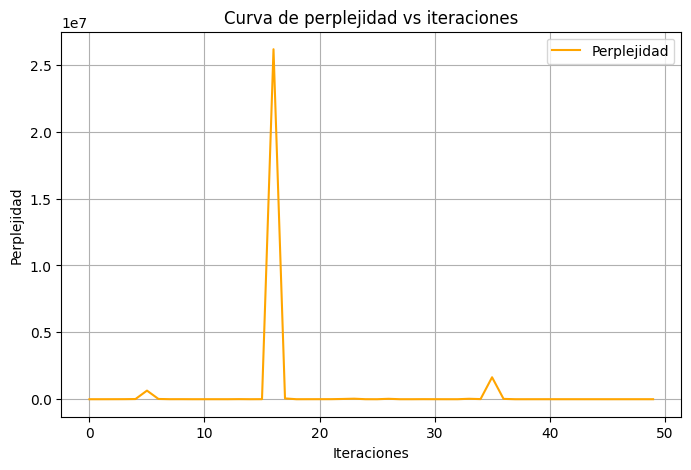

→ Nombre generado de ejemplo: s
ñóíóúéóé
✓ Experimento 3 completado - Loss final: 1383.7594, Perplexity final: 222.5853

=== CHARACTER-LEVEL - EXPERIMENTO 4/5 ===
Neuronas recurrentes: 256
Tamaño del dataset: 50000
Iteraciones/Épocas: 80
Clipping de gradientes: True
Iniciando entrenamiento...
Iteración 0 - Loss: 895.170 - Perplejidad: 33.008

--- Generando gráficas para Experimento 4 ---


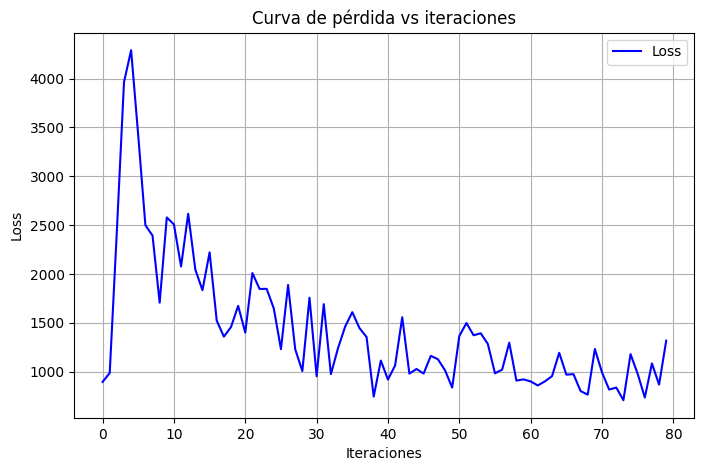

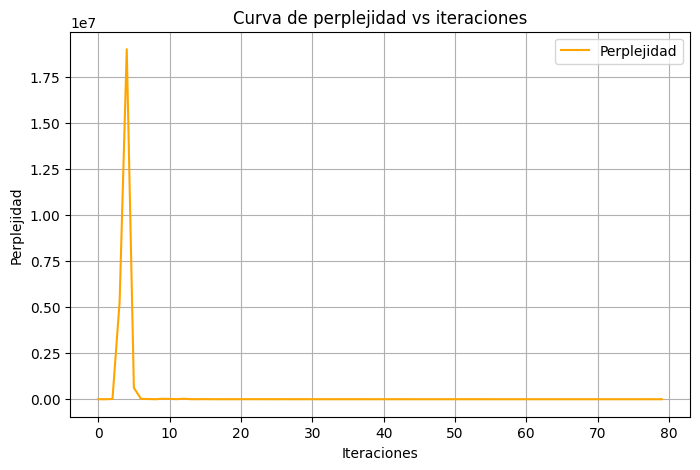

→ Nombre generado de ejemplo: 
afgúóñéñá
✓ Experimento 4 completado - Loss final: 1317.8019, Perplexity final: 172.0291

=== CHARACTER-LEVEL - EXPERIMENTO 5/5 ===
Neuronas recurrentes: 256
Tamaño del dataset: 50000
Iteraciones/Épocas: 80
Clipping de gradientes: False
Iniciando entrenamiento...
Iteración 0 - Loss: 895.129 - Perplejidad: 33.003

--- Generando gráficas para Experimento 5 ---


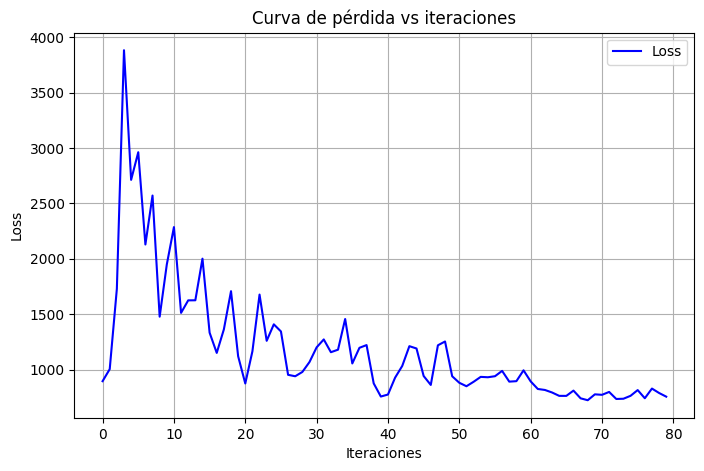

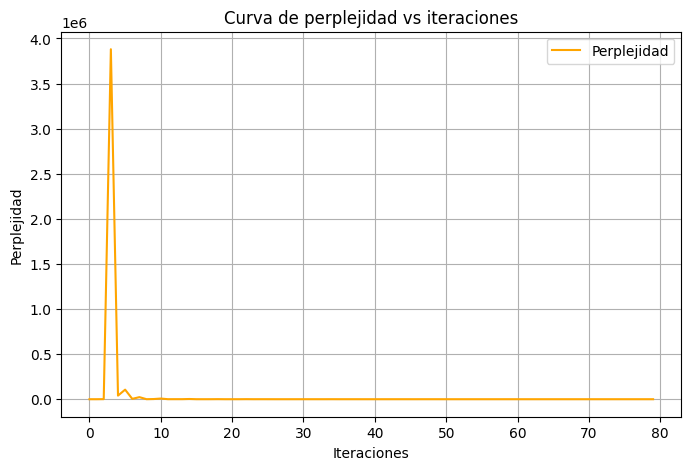

→ Nombre generado de ejemplo: iaeee
ba
n
✓ Experimento 5 completado - Loss final: 755.3781, Perplexity final: 19.1192

RESUMEN COMPARATIVO - CHARACTER-LEVEL MODELING

RANKING DE MODELOS (de mejor a peor perplexity):
--------------------------------------------------------------------------------
 1. Experimento  1 - Neuronas:  64, Dataset:  5000, Iter: 50, Clip:     1 | Loss: 163.8786, Perplexity: 12.9436 | Ejemplo: 'adeaaiestc'
 2. Experimento  5 - Neuronas: 256, Dataset: 50000, Iter: 80, Clip:     0 | Loss: 755.3781, Perplexity: 19.1192 | Ejemplo: 'iaeee
ba
n'
 3. Experimento  2 - Neuronas: 128, Dataset: 20000, Iter: 50, Clip:     1 | Loss: 462.5651, Perplexity: 37.1064 | Ejemplo: 'icrlig
sib'
 4. Experimento  4 - Neuronas: 256, Dataset: 50000, Iter: 80, Clip:     1 | Loss: 1317.8019, Perplexity: 172.0291 | Ejemplo: '
afgúóñéñá'
 5. Experimento  3 - Neuronas: 256, Dataset: 50000, Iter: 50, Clip:     1 | Loss: 1383.7594, Perplexity: 222.5853 | Ejemplo: 's
ñóíóúéóé'

COMPARACIÓN DIRECT

In [34]:
# Character-level language modeling experiments:

# Lista para almacenar resultados
results = []

# Definir 5 experimentos estratégicos para Character-level
experiments_char = [
    # seq_length (neuronas), dataset_size, max_iter, clip
    # --- 3 VARIACIONES PRINCIPALES ---
    (64, 5000, 50, True),    # Experimento 1: Configuración pequeña
    (128, 20000, 50, True),  # Experimento 2: Configuración media  
    (256, 50000, 50, True),  # Experimento 3: Configuración grande
    
    # --- 2 EXPERIMENTOS ADICIONALES CON/SIN CLIPPING ---
    (256, 50000, 80, True),  # Experimento 4: Con clipping
    (256, 50000, 80, False), # Experimento 5: Sin clipping
]

print(f"Total de experimentos Character-level: {len(experiments_char)}")

for i, (seq_length, dataset_size, max_iter, clip) in enumerate(experiments_char):
    print(f"\n{'='*60}")
    print(f"=== CHARACTER-LEVEL - EXPERIMENTO {i+1}/{len(experiments_char)} ===")
    print(f"{'='*60}")
    print(f"Neuronas recurrentes: {seq_length}")
    print(f"Tamaño del dataset: {dataset_size}")
    print(f"Iteraciones/Épocas: {max_iter}")
    print(f"Clipping de gradientes: {clip}")

    # Preparar datos y modelo
    subset_text = get_subset_text(text, dataset_size)
    rnn = VanillaRNN(n_x=len(char_to_int), n_h=seq_length, seq_length=seq_length, learning_rate=0.1)

    # Entrenamiento
    print("Iniciando entrenamiento...")
    loss_list, perplexity_list = rnn.train(subset_text, char_to_int, int_to_char, max_iter=max_iter, clip=clip)

    # **GRAFICAR PARA CADA EXPERIMENTO**
    print(f"\n--- Generando gráficas para Experimento {i+1} ---")
    
    # Gráfica de pérdida
    rnn.plot_loss(loss_list)
    
    # Gráfica de perplexity  
    rnn.plot_perplexity(perplexity_list)

    # Generar nombres de ejemplo
    hprev = np.zeros((rnn.n_h, 1))
    seed_ix = np.random.randint(0, len(char_to_int))
    sample_ix = rnn.make_sample(hprev, seed_ix, 10)
    generated = ''.join(int_to_char[ix] for ix in sample_ix)

    print(f"→ Nombre generado de ejemplo: {generated}")

    # Guardar resultados
    results.append({
        "experiment_id": i+1,
        "seq_length": seq_length,
        "dataset_size": dataset_size,
        "max_iter": max_iter,
        "clip": clip,
        "generated_example": generated,
        "final_loss": loss_list[-1],
        "final_perplexity": perplexity_list[-1],
        "loss_list": loss_list,
        "perplexity_list": perplexity_list
    })

    print(f"✓ Experimento {i+1} completado - Loss final: {loss_list[-1]:.4f}, Perplexity final: {perplexity_list[-1]:.4f}")

# --- Resumen comparativo detallado ---
print("\n" + "="*80)
print("RESUMEN COMPARATIVO - CHARACTER-LEVEL MODELING")
print("="*80)

# Ordenar resultados por perplexity (mejor a peor)
results_sorted = sorted(results, key=lambda x: x['final_perplexity'])

print("\nRANKING DE MODELOS (de mejor a peor perplexity):")
print("-" * 80)
for i, result in enumerate(results_sorted):
    print(f"{i+1:2d}. Experimento {result['experiment_id']:2d} - "
          f"Neuronas: {result['seq_length']:3d}, "
          f"Dataset: {result['dataset_size']:5d}, "
          f"Iter: {result['max_iter']:2d}, "
          f"Clip: {result['clip']:5} | "
          f"Loss: {result['final_loss']:7.4f}, "
          f"Perplexity: {result['final_perplexity']:7.4f} | "
          f"Ejemplo: '{result['generated_example']}'")

# --- Análisis de los experimentos con/sin clipping ---
print("\n" + "="*80)
print("COMPARACIÓN DIRECTA: CON vs SIN CLIPPING")
print("="*80)

# Buscar experimentos 4 y 5 (comparación directa clipping)
exp4 = results[3]  # Experimento 4 con clipping
exp5 = results[4]  # Experimento 5 sin clipping

print(f"\nExperimento 4 (CON clipping):")
print(f"  Neuronas: {exp4['seq_length']}, Dataset: {exp4['dataset_size']}, Iter: {exp4['max_iter']}")
print(f"  Loss final: {exp4['final_loss']:.4f}, Perplexity final: {exp4['final_perplexity']:.4f}")
print(f"  Ejemplo: '{exp4['generated_example']}'")

print(f"\nExperimento 5 (SIN clipping):")
print(f"  Neuronas: {exp5['seq_length']}, Dataset: {exp5['dataset_size']}, Iter: {exp5['max_iter']}")
print(f"  Loss final: {exp5['final_loss']:.4f}, Perplexity final: {exp5['final_perplexity']:.4f}")
print(f"  Ejemplo: '{exp5['generated_example']}'")

if exp4['final_perplexity'] < exp5['final_perplexity']:
    print(f"\n✓ El modelo CON clipping tuvo mejor performance (menor perplexity)")
    difference = exp5['final_perplexity'] - exp4['final_perplexity']
    print(f"  Diferencia: {difference:.4f} a favor del clipping")
else:
    print(f"\n✓ El modelo SIN clipping tuvo mejor performance (menor perplexity)")
    difference = exp4['final_perplexity'] - exp5['final_perplexity']
    print(f"  Diferencia: {difference:.4f} a favor de sin clipping")

# --- Análisis de escalado ---
print("\n" + "="*80)
print("ANÁLISIS DE ESCALADO: PEQUEÑO vs MEDIO vs GRANDE")
print("="*80)

print(f"\nConfiguración PEQUEÑA (Exp 1):")
print(f"  Neuronas: 64, Dataset: 5000, Iter: 50")
print(f"  Resultado: Loss={results[0]['final_loss']:.4f}, Perplexity={results[0]['final_perplexity']:.4f}")

print(f"\nConfiguración MEDIA (Exp 2):")
print(f"  Neuronas: 128, Dataset: 20000, Iter: 50")
print(f"  Resultado: Loss={results[1]['final_loss']:.4f}, Perplexity={results[1]['final_perplexity']:.4f}")

print(f"\nConfiguración GRANDE (Exp 3):")
print(f"  Neuronas: 256, Dataset: 50000, Iter: 50")
print(f"  Resultado: Loss={results[2]['final_loss']:.4f}, Perplexity={results[2]['final_perplexity']:.4f}")

# --- Generar más nombres con los 2 mejores modelos ---
print("\n" + "="*80)
print("GENERANDO MÁS NOMBRES CON LOS 2 MEJORES MODELOS")
print("="*80)

for i, best_result in enumerate(results_sorted[:2]):
    print(f"\n--- MEJOR MODELO #{i+1} (Experimento {best_result['experiment_id']}) ---")
    print(f"Hiperparámetros: Neuronas={best_result['seq_length']}, "
          f"Dataset={best_result['dataset_size']}, Iter={best_result['max_iter']}, "
          f"Clip={best_result['clip']}")
    print(f"Métricas: Loss={best_result['final_loss']:.4f}, Perplexity={best_result['final_perplexity']:.4f}")
    
    # Recrear el modelo para generar nombres
    subset_text = get_subset_text(text, best_result['dataset_size'])
    best_rnn = VanillaRNN(n_x=len(char_to_int), n_h=best_result['seq_length'], 
                          seq_length=best_result['seq_length'], learning_rate=0.1)
    
    # Re-entrenar rápidamente (o en un escenario real cargaríamos los pesos guardados)
    best_rnn.train(subset_text, char_to_int, int_to_char, max_iter=100, clip=best_result['clip'])
    
    hprev = np.zeros((best_rnn.n_h, 1))
    print("Nombres generados:")
    for j in range(10):
        seed_ix = np.random.randint(0, len(char_to_int))
        sample_ix = best_rnn.make_sample(hprev, seed_ix, 10)
        generated = ''.join(int_to_char[ix] for ix in sample_ix)
        print(f"  {j+1}: {generated}")

print(f"\n✓ Todos los {len(experiments_char)} experimentos Character-level completados!")
print("✓ Gráficas individuales generadas para cada experimento")
print("✓ Análisis comparativo realizado")

# Word-level language modeling experiments

Total de experimentos Shakespeare (Word-level): 5

=== SHAKESPEARE WORD-LEVEL - EXPERIMENTO 1/5 ===
Neuronas recurrentes: 64
Tamaño del dataset (tokens): 5000
Iteraciones/Épocas: 50
Clipping de gradientes: True
Iniciando entrenamiento...
Iteración 0 - Loss: 603.089 - Perplejidad: 12372.916

--- Generando gráficas para Experimento 1 ---


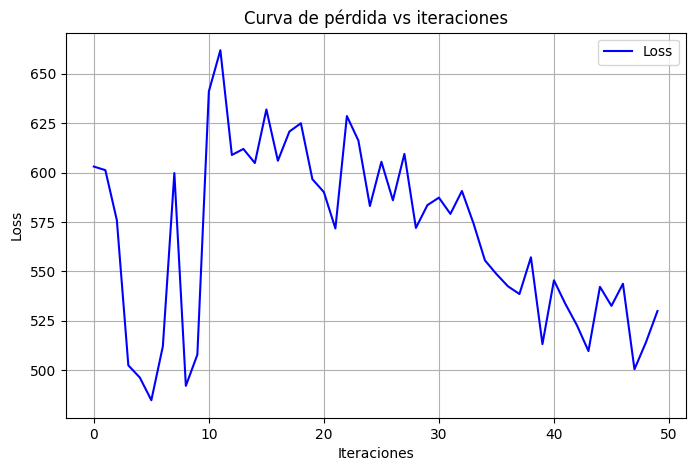

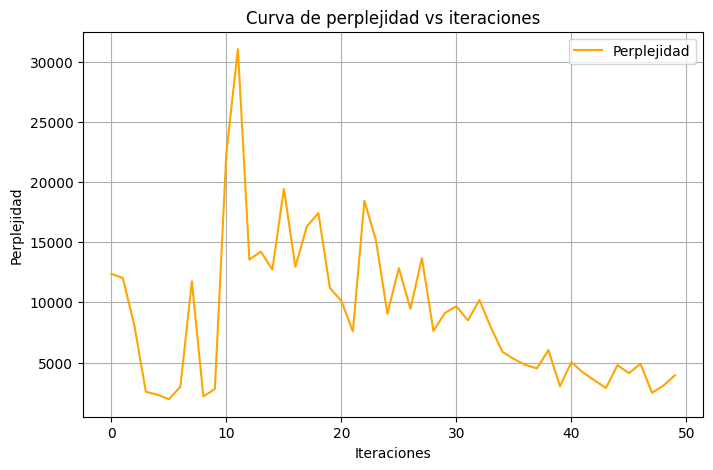

→ Texto generado de ejemplo: assisting sincerely of mouthed humanely direful than knocks weighs on pocket let is plaintain company undescried slowly rebell'd learn counsellor
✓ Experimento 1 completado - Loss final: 529.9602, Perplexity final: 3946.6715

=== SHAKESPEARE WORD-LEVEL - EXPERIMENTO 2/5 ===
Neuronas recurrentes: 128
Tamaño del dataset (tokens): 20000
Iteraciones/Épocas: 50
Clipping de gradientes: True
Iniciando entrenamiento...
Iteración 0 - Loss: 1206.175 - Perplejidad: 12372.605

--- Generando gráficas para Experimento 2 ---


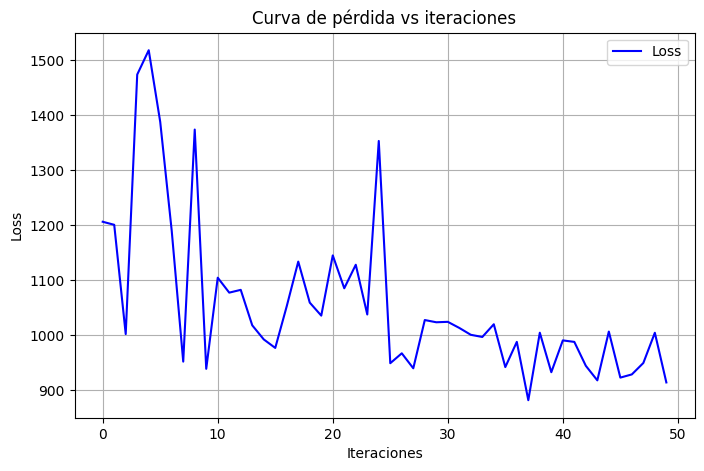

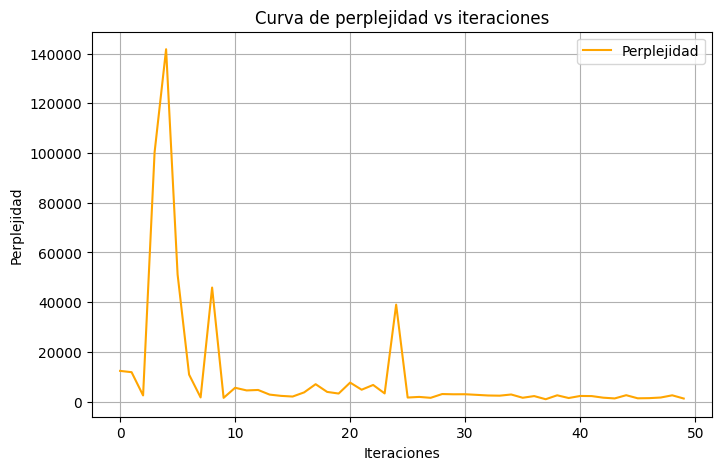

→ Texto generado de ejemplo: remission pour'd the know love the first must south am pray my but you love subtle to my shall own
✓ Experimento 2 completado - Loss final: 913.8182, Perplexity final: 1260.4258

=== SHAKESPEARE WORD-LEVEL - EXPERIMENTO 3/5 ===
Neuronas recurrentes: 256
Tamaño del dataset (tokens): 50000
Iteraciones/Épocas: 50
Clipping de gradientes: True
Iniciando entrenamiento...
Iteración 0 - Loss: 2412.412 - Perplejidad: 12375.622

--- Generando gráficas para Experimento 3 ---


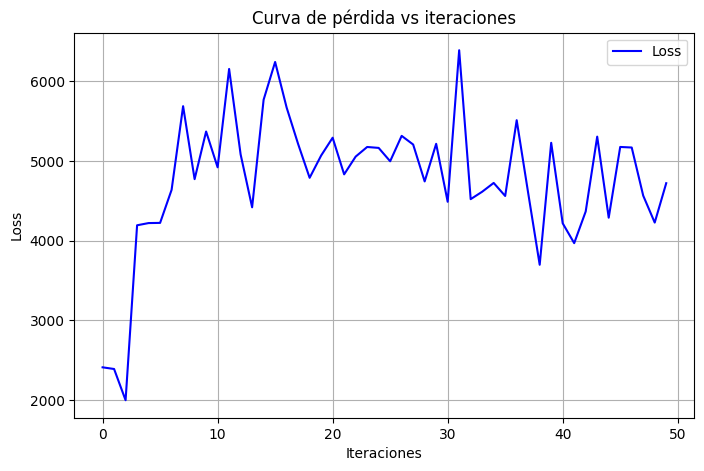

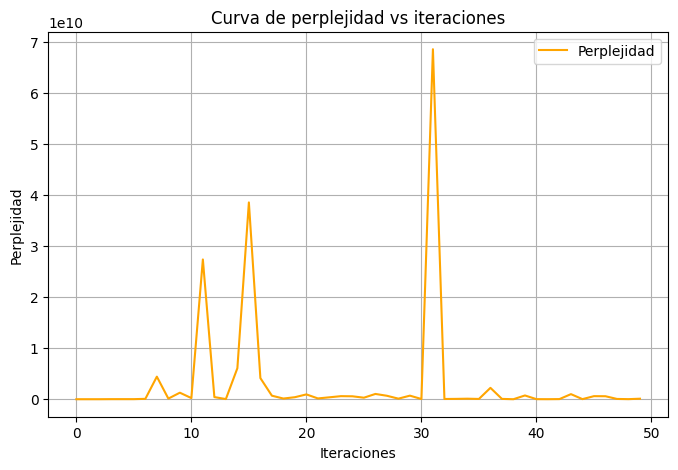

→ Texto generado de ejemplo: tis menenius now this not as now now as as the now their now as not as now i which
✓ Experimento 3 completado - Loss final: 4720.7452, Perplexity final: 101992629.2442

=== SHAKESPEARE WORD-LEVEL - EXPERIMENTO 4/5 ===
Neuronas recurrentes: 128
Tamaño del dataset (tokens): 50000
Iteraciones/Épocas: 80
Clipping de gradientes: True
Iniciando entrenamiento...
Iteración 0 - Loss: 1206.181 - Perplejidad: 12373.215

--- Generando gráficas para Experimento 4 ---


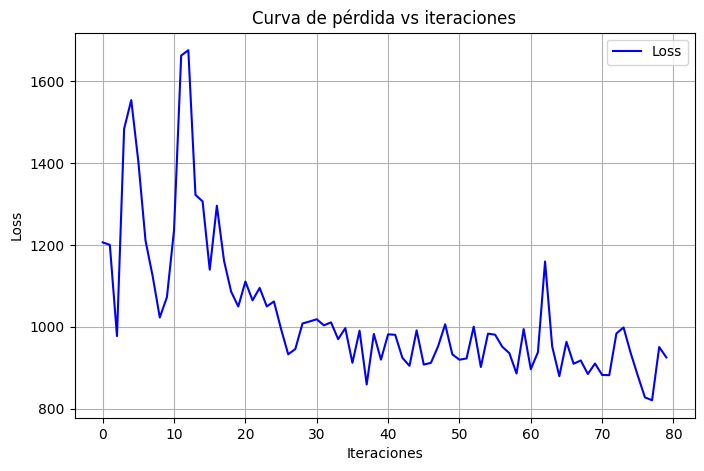

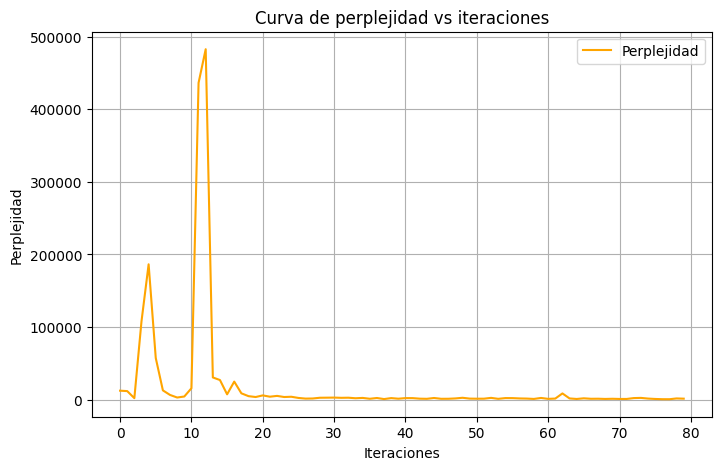

→ Texto generado de ejemplo: smelling tinkers carters heaviest sorrow gape overgo tale's curses robs suited expect'st affairs liege coronation swayed tush chattering unhappiness merriman
✓ Experimento 4 completado - Loss final: 925.3230, Perplexity final: 1378.9619

=== SHAKESPEARE WORD-LEVEL - EXPERIMENTO 5/5 ===
Neuronas recurrentes: 128
Tamaño del dataset (tokens): 50000
Iteraciones/Épocas: 80
Clipping de gradientes: False
Iniciando entrenamiento...
Iteración 0 - Loss: 1206.169 - Perplejidad: 12372.097

--- Generando gráficas para Experimento 5 ---


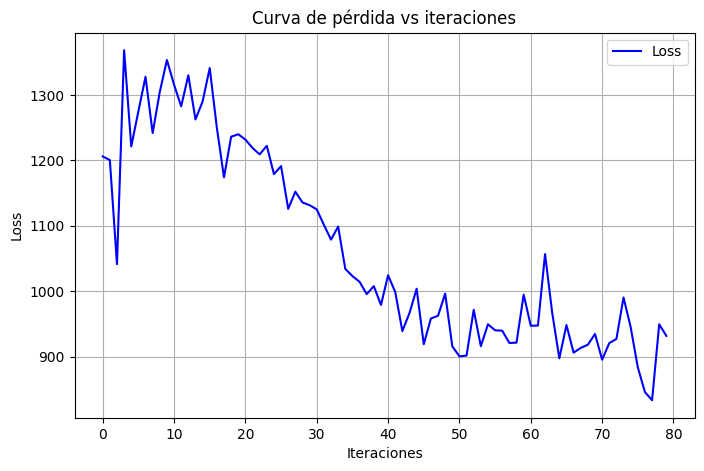

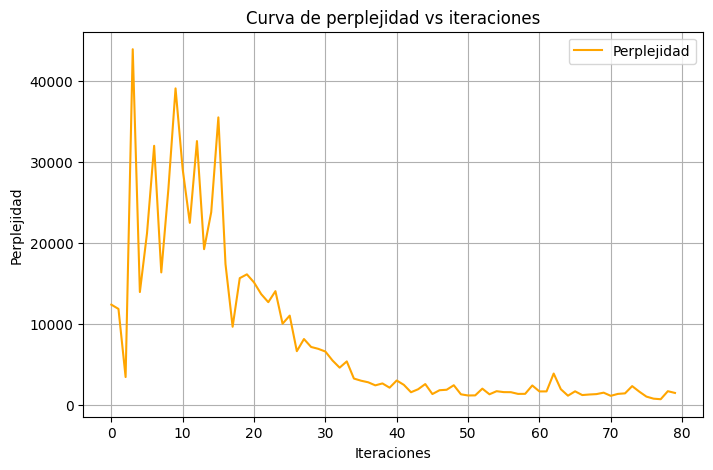

→ Texto generado de ejemplo: glances have done hardiness the commendable muck the way curbs you he fresh and menenius take to without thou awhile
✓ Experimento 5 completado - Loss final: 931.7608, Perplexity final: 1450.0900

RESUMEN COMPARATIVO - SHAKESPEARE WORD-LEVEL MODELING

RANKING DE MODELOS (de mejor a peor perplexity):
--------------------------------------------------------------------------------
 1. Experimento  2 - Neuronas: 128, Dataset: 20000, Iter: 50, Clip:     1 | Loss: 913.8182, Perplexity: 1260.4258
 2. Experimento  4 - Neuronas: 128, Dataset: 50000, Iter: 80, Clip:     1 | Loss: 925.3230, Perplexity: 1378.9619
 3. Experimento  5 - Neuronas: 128, Dataset: 50000, Iter: 80, Clip:     0 | Loss: 931.7608, Perplexity: 1450.0900
 4. Experimento  1 - Neuronas:  64, Dataset:  5000, Iter: 50, Clip:     1 | Loss: 529.9602, Perplexity: 3946.6715
 5. Experimento  3 - Neuronas: 256, Dataset: 50000, Iter: 50, Clip:     1 | Loss: 4720.7452, Perplexity: 101992629.2442

COMPARACIÓN 

In [33]:
# Word-level language modeling experiments - Shakespeare

# Definir 5 experimentos estratégicos para Shakespeare
experiments_shakespeare = [
    # seq_length, dataset_size, max_iter, clip
    # --- 3 VARIACIONES PRINCIPALES ---
    (64, 5000, 50, True),    # Experimento 1: Configuración pequeña
    (128, 20000, 50, True),  # Experimento 2: Configuración media  
    (256, 50000, 50, True),  # Experimento 3: Configuración grande
    
    # --- 2 EXPERIMENTOS ADICIONALES CON/SIN CLIPPING ---
    (128, 50000, 80, True),  # Experimento 4: Con clipping
    (128, 50000, 80, False), # Experimento 5: Sin clipping
]

print(f"Total de experimentos Shakespeare (Word-level): {len(experiments_shakespeare)}")

# Lista para almacenar resultados de Shakespeare
results_shakespeare = []

def get_subset_tokens(encoded, size):
    size = min(size, len(encoded))
    return encoded[:size]

def train_word(self, encoded, max_iter=10000, clip=True):
    iter_num, pos = 0, 0
    loss_list, perplexity_list = [], []
    hprev = np.zeros((self.n_h, 1))
    N = len(encoded)
    
    while iter_num < max_iter:
        if pos + self.seq_length + 1 >= N or iter_num == 0:
            hprev = np.zeros((self.n_h, 1))
            pos = 0

        inputs = encoded[pos:pos+self.seq_length]
        targets = encoded[pos+1:pos+self.seq_length+1]
        pos += self.seq_length

        # Forward pass
        loss, x, h, p = self.forward_pass(inputs, targets, hprev)
        loss_list.append(loss)
        perplexity_list.append(np.exp(loss / self.seq_length))

        # Backpropagation
        dWxh, dWhh, dWhy, dbh, dby = self.backpropagation(x, h, p, targets, clip=clip)
        self.update_para(dWxh, dWhh, dWhy, dbh, dby)
        hprev = h[self.seq_length - 1]

        if iter_num % 1000 == 0:
            print(f"Iteración {iter_num} - Loss: {loss:.3f} - Perplejidad: {np.exp(loss/self.seq_length):.3f}")
        iter_num += 1

    return loss_list, perplexity_list

def make_sample_words(self, hprev, seed_ix, n):
    x = np.zeros((self.n_x, 1))
    x[seed_ix] = 1
    ixes = []
    h = np.copy(hprev)

    for t in range(n):
        h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
        y = self.Why @ h + self.by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(self.n_x), p=p.ravel())
        x = np.zeros((self.n_x, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

# Añadir métodos a la clase VanillaRNN
VanillaRNN.train_word = train_word
VanillaRNN.make_sample_words = make_sample_words

# Ejecutar experimentos
for i, (seq_length, dataset_size, max_iter, clip) in enumerate(experiments_shakespeare):
    print(f"\n{'='*60}")
    print(f"=== SHAKESPEARE WORD-LEVEL - EXPERIMENTO {i+1}/{len(experiments_shakespeare)} ===")
    print(f"{'='*60}")
    print(f"Neuronas recurrentes: {seq_length}")
    print(f"Tamaño del dataset (tokens): {dataset_size}")
    print(f"Iteraciones/Épocas: {max_iter}")
    print(f"Clipping de gradientes: {clip}")

    # Preparar datos
    subset_encoded = get_subset_tokens(encoded, dataset_size)
    
    # Verificar que el dataset sea suficientemente grande
    if len(subset_encoded) <= seq_length + 1:
        print("→ Saltado: dataset_size <= seq_length+1")
        results_shakespeare.append({
            "experiment_id": i+1,
            "seq_length": seq_length,
            "dataset_size": dataset_size,
            "max_iter": max_iter,
            "clip": clip,
            "status": "skipped: dataset too small"
        })
        continue

    # Crear y entrenar modelo
    rnn = VanillaRNN(n_x=vocab_size, n_h=seq_length, seq_length=seq_length, learning_rate=0.05)

    print("Iniciando entrenamiento...")
    loss_list, perplexity_list = rnn.train_word(subset_encoded, max_iter=max_iter, clip=clip)

    # **GRAFICAR PARA CADA EXPERIMENTO**
    print(f"\n--- Generando gráficas para Experimento {i+1} ---")
    
    # Gráfica de pérdida
    rnn.plot_loss(loss_list)
    
    # Gráfica de perplexity  
    rnn.plot_perplexity(perplexity_list)

    # Generar texto de ejemplo
    hprev = np.zeros((rnn.n_h, 1))
    seed_word = "the" if "the" in word_to_int else next(iter(word_to_int.keys()))
    seed_ix = word_to_int[seed_word]
    sample_ix = rnn.make_sample_words(hprev, seed_ix, n=20)  # 20 palabras para un párrafo
    generated = ' '.join(int_to_word[ix] for ix in sample_ix)

    print(f"→ Texto generado de ejemplo: {generated}")

    # Guardar resultados
    results_shakespeare.append({
        "experiment_id": i+1,
        "seq_length": seq_length,
        "dataset_size": dataset_size,
        "max_iter": max_iter,
        "clip": clip,
        "generated_example": generated,
        "final_loss": loss_list[-1],
        "final_perplexity": perplexity_list[-1],
        "loss_list": loss_list,
        "perplexity_list": perplexity_list
    })

    print(f"✓ Experimento {i+1} completado - Loss final: {loss_list[-1]:.4f}, Perplexity final: {perplexity_list[-1]:.4f}")

# --- Resumen comparativo detallado ---
print("\n" + "="*80)
print("RESUMEN COMPARATIVO - SHAKESPEARE WORD-LEVEL MODELING")
print("="*80)

# Ordenar resultados por perplexity (mejor a peor)
results_shakespeare_sorted = sorted([r for r in results_shakespeare if 'status' not in r], 
                                   key=lambda x: x['final_perplexity'])

print("\nRANKING DE MODELOS (de mejor a peor perplexity):")
print("-" * 80)
for i, result in enumerate(results_shakespeare_sorted):
    print(f"{i+1:2d}. Experimento {result['experiment_id']:2d} - "
          f"Neuronas: {result['seq_length']:3d}, "
          f"Dataset: {result['dataset_size']:5d}, "
          f"Iter: {result['max_iter']:2d}, "
          f"Clip: {result['clip']:5} | "
          f"Loss: {result['final_loss']:7.4f}, "
          f"Perplexity: {result['final_perplexity']:7.4f}")

# --- Análisis de los experimentos con/sin clipping ---
print("\n" + "="*80)
print("COMPARACIÓN DIRECTA: CON vs SIN CLIPPING")
print("="*80)

# Buscar experimentos 4 y 5 (comparación directa clipping)
exp4 = results_shakespeare[3] if len(results_shakespeare) > 3 else None
exp5 = results_shakespeare[4] if len(results_shakespeare) > 4 else None

if exp4 and exp5 and 'status' not in exp4 and 'status' not in exp5:
    print(f"\nExperimento 4 (CON clipping):")
    print(f"  Neuronas: {exp4['seq_length']}, Dataset: {exp4['dataset_size']}, Iter: {exp4['max_iter']}")
    print(f"  Loss final: {exp4['final_loss']:.4f}, Perplexity final: {exp4['final_perplexity']:.4f}")
    print(f"  Texto generado: '{exp4['generated_example']}'")

    print(f"\nExperimento 5 (SIN clipping):")
    print(f"  Neuronas: {exp5['seq_length']}, Dataset: {exp5['dataset_size']}, Iter: {exp5['max_iter']}")
    print(f"  Loss final: {exp5['final_loss']:.4f}, Perplexity final: {exp5['final_perplexity']:.4f}")
    print(f"  Texto generado: '{exp5['generated_example']}'")

    if exp4['final_perplexity'] < exp5['final_perplexity']:
        print(f"\n✓ El modelo CON clipping tuvo mejor performance (menor perplexity)")
        difference = exp5['final_perplexity'] - exp4['final_perplexity']
        print(f"  Diferencia: {difference:.4f} a favor del clipping")
    else:
        print(f"\n✓ El modelo SIN clipping tuvo mejor performance (menor perplexity)")
        difference = exp4['final_perplexity'] - exp5['final_perplexity']
        print(f"  Diferencia: {difference:.4f} a favor de sin clipping")

# --- Análisis de escalado ---
print("\n" + "="*80)
print("ANÁLISIS DE ESCALADO: PEQUEÑO vs MEDIO vs GRANDE")
print("="*80)

if len(results_shakespeare) >= 3:
    print(f"\nConfiguración PEQUEÑA (Exp 1):")
    print(f"  Neuronas: 64, Dataset: 5000, Iter: 50")
    if 'status' not in results_shakespeare[0]:
        print(f"  Resultado: Loss={results_shakespeare[0]['final_loss']:.4f}, Perplexity={results_shakespeare[0]['final_perplexity']:.4f}")
        print(f"  Texto: '{results_shakespeare[0]['generated_example']}'")

    print(f"\nConfiguración MEDIA (Exp 2):")
    print(f"  Neuronas: 128, Dataset: 20000, Iter: 50")
    if 'status' not in results_shakespeare[1]:
        print(f"  Resultado: Loss={results_shakespeare[1]['final_loss']:.4f}, Perplexity={results_shakespeare[1]['final_perplexity']:.4f}")
        print(f"  Texto: '{results_shakespeare[1]['generated_example']}'")

    print(f"\nConfiguración GRANDE (Exp 3):")
    print(f"  Neuronas: 256, Dataset: 50000, Iter: 50")
    if 'status' not in results_shakespeare[2]:
        print(f"  Resultado: Loss={results_shakespeare[2]['final_loss']:.4f}, Perplexity={results_shakespeare[2]['final_perplexity']:.4f}")
        print(f"  Texto: '{results_shakespeare[2]['generated_example']}'")

# --- Generar párrafos más largos con los 2 mejores modelos ---
print("\n" + "="*80)
print("GENERANDO PÁRRAFOS CON LOS 2 MEJORES MODELOS")
print("="*80)

for i, best_result in enumerate(results_shakespeare_sorted[:2]):
    print(f"\n--- MEJOR MODELO #{i+1} (Experimento {best_result['experiment_id']}) ---")
    print(f"Hiperparámetros: Neuronas={best_result['seq_length']}, "
          f"Dataset={best_result['dataset_size']}, Iter={best_result['max_iter']}, "
          f"Clip={best_result['clip']}")
    print(f"Métricas: Loss={best_result['final_loss']:.4f}, Perplexity={best_result['final_perplexity']:.4f}")
    
    # Recrear el modelo para generar texto
    subset_encoded = get_subset_tokens(encoded, best_result['dataset_size'])
    best_rnn = VanillaRNN(n_x=vocab_size, n_h=best_result['seq_length'], 
                          seq_length=best_result['seq_length'], learning_rate=0.05)
    
    # Re-entrenar rápidamente
    best_rnn.train_word(subset_encoded, max_iter=100, clip=best_result['clip'])
    
    hprev = np.zeros((best_rnn.n_h, 1))
    seed_word = "the" if "the" in word_to_int else next(iter(word_to_int.keys()))
    seed_ix = word_to_int[seed_word]
    
    print("Párrafo generado:")
    sample_ix = best_rnn.make_sample_words(hprev, seed_ix, n=50)  # 50 palabras para un párrafo
    generated_paragraph = ' '.join(int_to_word[ix] for ix in sample_ix)
    print(f"  '{generated_paragraph}'")

print(f"\n✓ Todos los {len(experiments_shakespeare)} experimentos Shakespeare completados!")
print("✓ Gráficas individuales generadas para cada experimento")
print("✓ Análisis comparativo realizado")

NOTA: Para obtener sólo las gráficas para el punto 1, correr sólo las celdas: imports, classVanillaRNN y with open

In [13]:
#Change the path. This was coded in colab
with open(r'C:\Users\Laura\OneDrive\Escritorio\taller2-RN\input.txt', 'r', encoding='utf-8') as f:
    text = f.read()


chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)

rnn = VanillaRNN(n_x=vocab_size, n_h=100, seq_length=25, learning_rate=1e-1)
loss_list, perplexity_list = rnn.train(text, char_to_int, int_to_char, max_iter=5000, clip=True)


rnn.plot_loss(loss_list)
rnn.plot_perplexity(perplexity_list)

ZeroDivisionError: float division by zero

This is the content used in input.txt:

kmmatody: nomels bake tho pav.

M:
Atw: and I; thou onsel swere, lo! meroses ssseme noke shy ust but ker, woncter id imire ghy.

What Thes hereth:
Iss:
Drou wort, netesteme here to whont toy,
All My